# Homework 05 - Taming text

## Exercise 1 - Generating word clouds

### Step one - Using the raw corpus

In this part we will use the raw email contents with minimal pre-processing to generate a word cloud using the [word_cloud](https://github.com/amueller/word_cloud) library.

In [109]:
# Imports
import numpy as np
import pandas as pd
from wordcloud import WordCloud as wc
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk import WordNetLemmatizer as wnl
import nltk
import re
import pycountry as pc
from PIL import Image
from os import path
from nltk.sentiment import SentimentIntensityAnalyzer as st

%matplotlib inline

In [102]:
# Uncomment and Run to download packages for nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

First we load the email data, try to understand it's structure and choose which fields to use.

In [3]:
raw_emails = pd.read_csv('hillary-clinton-emails/Emails.csv')
raw_emails.head()

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\r\nU.S. Department of State\r\nCa...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\r\nThursday, March 3, 2011 9:45 PM\r\nH: La...",UNCLASSIFIED\r\nU.S. Department of State\r\nCa...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\r\nU.S. Department of State\r\nCa...
3,4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,...,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,NaN,UNCLASSIFIED\r\nU.S. Department of State\r\nCa...
4,5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\r\nFriday, March 1...",B6\r\nUNCLASSIFIED\r\nU.S. Department of State...


It seems that the `ExtractedBodyText` field is what we would like to work with. However there are some missing values. Let's see if there are many of them.

In [4]:
print('Number of emails with null ExtractedBodyText:', raw_emails['ExtractedBodyText'].isnull().sum())
print('Total number of emails:', len(raw_emails))

Number of emails with null ExtractedBodyText: 1203
Total number of emails: 7945


So we will not use this field. We will instead use `RawText` and do some minimal preprocessing on it to remove irrelevant parts.

In [5]:
def preprocess_raw_email(text):
    """Very simple email preprocessing that tries to remove
    email protocol metadata and standard headers"""
    
    keywords = ('U.S. Department of State', 'Department of State', 'Case No.',
                'Doc No.', 'STATE DEPT.', 'UNCLASSIFIED',
                'From:', 'To:', 'Sent:', 'Subject:', 'Attachments:',
                'Date:', 'Cc:')
    
    # Remove lines starting with keyword
    lines = text.split('\n')
    lines = [ l for l in lines if not l.startswith(keywords) ]
    
    return '\n'.join(lines)

In [6]:
def cloud(text): 
    """ Generate wordcloud """
    text = ' '.join(text) if type(text) != str else text
    wordcloud = wc(max_font_size=80, stopwords=[""], width=500, height=250, background_color='White').generate(text)
    plt.figure(figsize=(10,50))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    

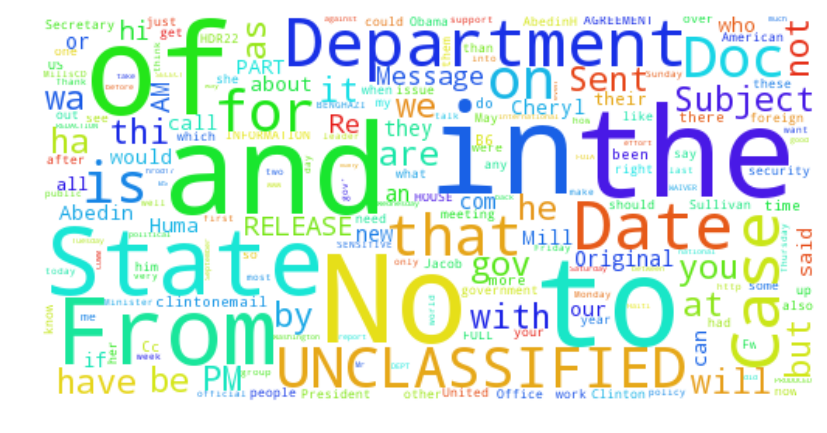

In [7]:
raw_text = raw_emails['RawText']
cloud(raw_text)

### Step two - Text processing pipeline

Let us first define a cutom function that tries to remove the content we do not want to consider for building the word cloud. We want to focus on the email body content so we try to remove
- Email protocol details (sender, recipient, etc.)
- Unclassified status
- U.S. Department of State and other recurrent headers
- Case and document numbers

In [8]:
def preprocess_raw_email(text):
    """Very simple email preprocessing that tries to remove
    email protocol metadata and standard headers"""
    
    keywords = ('U.S. Department of State', 'Department of State', 'Case No.',
                'Doc No.', 'STATE DEPT.', 'UNCLASSIFIED',
                'From:', 'To:', 'Sent:', 'Subject:', 'Attachments:',
                'Date:', 'Cc:')
    
    # Remove lines starting with keyword
    lines = text.split('\n')
    lines = [ l for l in lines if not l.startswith(keywords) ]
    
    return '\n'.join(lines)

In [9]:
text = '\n'.join(raw_text.map(preprocess_raw_email)).strip().lower()

Tokenisation

In [10]:
tokenizer = RegexpTokenizer(r'\w+')
basic_tokens = tokenizer.tokenize(text)

Remove punctuations and numbers

In [38]:
# punctuation and numbers to be removed
punctuation = re.compile(r'[_\<\>\@\-\.\?!,":;()|0-9]')
single_letter = re.compile('^([a-z]|[A-Z])$')
tokens = [punctuation.sub("", word) for word in basic_tokens]  
tokens = [single_letter.sub("", word) for word in tokens]  
tokens = filter(None, tokens)

Remove stopwords

In [12]:
my_stopwords = stopwords.words('english')
filtered_tokens = [ t for t in tokens if t not in my_stopwords]

Lemmatization

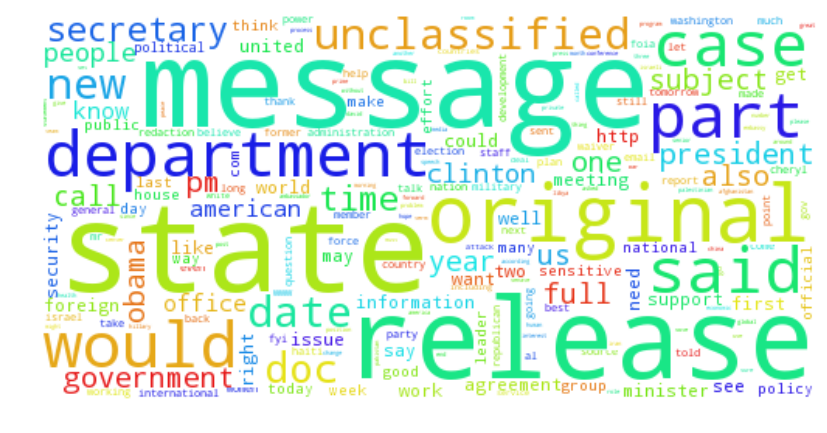

In [13]:
cloud(filtered_tokens)

# Exercise 2

In [14]:
text2 = '\n'.join(raw_text.map(preprocess_raw_email)).strip()

In [15]:
preprocessed = []
for x in raw_text:
    preprocessed.append(preprocess_raw_email(x))
    
df2 = pd.DataFrame(preprocessed, columns=['Emails']) 

In [47]:
dic = {}
i = 0
for em in preprocessed:
    basic_tokens = tokenizer.tokenize(em)
    tokens = [punctuation.sub("", word) for word in basic_tokens]  
    tokens = [single_letter.sub("", word) for word in tokens]  
    tokens = filter(None, tokens)
    my_stopwords = stopwords.words('english')+["cc, re, fw, fwd, com, pm"]
    filtered_tokens = [ t for t in tokens if t.lower() not in my_stopwords]
    dic[i] = filtered_tokens
    i = i+1

In [88]:
my_index = {}
for (k,v_arr) in dic.items():
    my_index[k] = set()
    for v in v_arr:
        try:
            if(v.lower() == 'uk' or v == 'US'):
                my_index[k].add(pc.countries.lookup(v).name)
            else:
                country = pc.countries.lookup(v)
                if(country.name == v):
                    my_index[k].add(country.name)
        except:
            ;
        

In [91]:
emails_with_countries = {}
for (k,v) in my_index.items():
    if len(my_index[k])>0:
        emails_with_countries[k] = [cs for cs in v ]
    

In [92]:
emails_with_countries

{1: ['Turkey',
  'Egypt',
  'Sudan',
  'France',
  'Israel',
  'Lebanon',
  'Libya',
  'Spain'],
 3: ['Egypt'],
 4: ['Turkey',
  'Egypt',
  'Sudan',
  'France',
  'Israel',
  'Lebanon',
  'Libya',
  'Spain'],
 6: ['Iraq', 'Egypt', 'Afghanistan', 'Libya'],
 7: ['Turkey',
  'Egypt',
  'Sudan',
  'France',
  'Israel',
  'Lebanon',
  'Libya',
  'Spain'],
 8: ['Morocco', 'Libya'],
 9: ['Afghanistan', 'Egypt', 'Sudan', 'Libya', 'Yemen'],
 10: ['France', 'Libya'],
 11: ['Afghanistan', 'Egypt', 'Sudan', 'Libya', 'Yemen'],
 13: ['Iraq', 'France', 'China', 'Afghanistan', 'Libya'],
 14: ['Libya'],
 15: ['Malta'],
 16: ['Libya'],
 18: ['Gibraltar'],
 19: ['Libya'],
 20: ['Afghanistan', 'Egypt', 'Sudan', 'Libya', 'Yemen'],
 21: ['Libya'],
 22: ['Afghanistan', 'Egypt', 'Mali', 'Libya', 'United States'],
 23: ['Afghanistan', 'Egypt', 'Mali', 'Libya', 'United States'],
 25: ['Afghanistan', 'Egypt', 'Sudan', 'Libya', 'Yemen'],
 28: ['Egypt', 'Libya', 'Yemen'],
 29: ['Malta'],
 30: ['Egypt', 'Libya'],
 

dict_keys([1, 3, 4, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 25, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 40, 42, 43, 44, 45, 46, 47, 48, 50, 52, 53, 54, 55, 57, 58, 61, 63, 64, 65, 66, 67, 69, 70, 71, 72, 73, 75, 76, 77, 79, 80, 82, 83, 84, 85, 87, 89, 91, 92, 94, 95, 96, 97, 98, 99, 101, 103, 104, 107, 109, 110, 111, 112, 113, 114, 115, 117, 118, 119, 120, 121, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 138, 139, 141, 142, 143, 146, 147, 148, 149, 150, 152, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 174, 176, 177, 178, 179, 180, 183, 184, 186, 187, 188, 189, 190, 191, 193, 194, 196, 198, 199, 200, 201, 202, 203, 204, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 219, 221, 222, 224, 225, 226, 227, 228, 232, 233, 236, 237, 238, 239, 240, 242, 243, 251, 253, 254, 255, 256, 257, 258, 259, 261, 262, 263, 264, 265, 266, 267, 268, 269, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 2

In [139]:
vader_analyzer = st()
sentiments = {}
for (k,v_arr) in emails_with_countries.items():
    sentiments[k] = vader_analyzer.polarity_scores(preprocessed[k])
write(sentiments, 'sentiments')    

In [137]:
import json
def write(my_dict, name):
    json.dump(my_dict, open(name+".json",'w'))

    
def read(name):
    json.load(open(name+".json"))

In [138]:
#writecsv(sentiments, 'sentiments')
write(emails_with_countries, 'emails_with_countries')


In [112]:
countries_sentiments = {}
for (k,v_arr) in emails_with_countries.items():
    for v in v_arr:
        if(v not in countries_sentiments.keys()):
            countries_sentiments[v] = []
        countries_sentiments[v].append(sentiments[k])
        

{1: {'compound': 0.9872, 'neg': 0.06, 'neu': 0.848, 'pos': 0.091},
 3: {'compound': 0.1111, 'neg': 0.109, 'neu': 0.779, 'pos': 0.112},
 4: {'compound': 0.9873, 'neg': 0.065, 'neu': 0.841, 'pos': 0.093},
 6: {'compound': -0.9966, 'neg': 0.146, 'neu': 0.789, 'pos': 0.065},
 7: {'compound': 0.986, 'neg': 0.068, 'neu': 0.837, 'pos': 0.095},
 8: {'compound': 0.9992, 'neg': 0.121, 'neu': 0.672, 'pos': 0.207},
 9: {'compound': -0.9923, 'neg': 0.143, 'neu': 0.743, 'pos': 0.114},
 10: {'compound': 0.0982, 'neg': 0.051, 'neu': 0.889, 'pos': 0.06},
 11: {'compound': -0.9923, 'neg': 0.143, 'neu': 0.743, 'pos': 0.114},
 13: {'compound': 0.995, 'neg': 0.078, 'neu': 0.8, 'pos': 0.122},
 14: {'compound': 0.9884, 'neg': 0.035, 'neu': 0.768, 'pos': 0.197},
 15: {'compound': 0.9508, 'neg': 0.042, 'neu': 0.796, 'pos': 0.162},
 16: {'compound': 0.7096, 'neg': 0.116, 'neu': 0.672, 'pos': 0.213},
 18: {'compound': 0.9851, 'neg': 0.053, 'neu': 0.697, 'pos': 0.25},
 19: {'compound': 0.6208, 'neg': 0.13, 'neu':